In [3]:
import torch
import torch.nn as nn

import unidecode
import string
import random

import matplotlib.pyplot as plt

In [4]:
all_characters = string.printable
n_characters = len(all_characters)

file = unidecode.unidecode(open('../data/shakespeare.txt').read())
file_len = len(file)

In [5]:
chunk_len = 200

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

def random_training_set():
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return tensor

In [6]:
n_epochs = 2000
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 1
lr = 0.005

In [15]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(Model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = torch.nn.Embedding(input_size, hidden_size)
        self.rnn = torch.nn.RNN(hidden_size, hidden_size, n_layers)
        self.decoder = torch.nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.rnn(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return torch.zeros(self.n_layers, 1, self.hidden_size)

In [52]:
model = Model(n_characters, hidden_size, hidden_size)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
lossfn = torch.nn.CrossEntropyLoss()

In [59]:
all_losses = []
loss_avg = 0

def train(inp, target):
    hidden = model.init_hidden()
    model.zero_grad()
    loss = 0
    for c in range(chunk_len):
        output, hidden = model(inp[c], hidden)
        loss += lossfn(output, target[c].reshape(1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss / chunk_len

def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    hidden = model.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    for p in range(len(prime_str) - 1):
        _, hidden = model(prime_input[p], hidden)
    inp = prime_input[-1]

    for p in range(predict_len):
        output, hidden = model(inp, hidden)

        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]

        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())
    loss_avg += loss

    if epoch % print_every == 0:
        print('[(%d %d%%) %.4f]' % (epoch, float(epoch) / n_epochs * 100, loss))

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

[(100 5%) 1.8849]
[(200 10%) 1.9730]
[(300 15%) 1.8705]
[(400 20%) 1.8708]
[(500 25%) 2.1193]
[(600 30%) 1.7717]
[(700 35%) 1.7826]
[(800 40%) 1.7427]
[(900 45%) 2.1614]
[(1000 50%) 1.7844]
[(1100 55%) 2.0272]
[(1200 60%) 1.6959]
[(1300 65%) 1.8420]
[(1400 70%) 1.6987]
[(1500 75%) 1.8076]
[(1600 80%) 1.9710]
[(1700 85%) 1.7485]
[(1800 90%) 1.6915]
[(1900 95%) 1.7054]
[(2000 100%) 1.8983]


Happy birthday!
What was with lieth hall lover for a?
Ever sired to eas here and lads us so his have a seappier?

C
Happy birthday!
When and he maki'ds the ciendy of so to your eeder you lown
Wis some
Thy lave sears the hear me fis
Happy birthday!

CAPULEESTIO:
But beder, in surer the read.
Wand stender tell a shall the upon and net.

HENRY VINC
Happy birthday! I speep.

BORTHERE:
You oum Mesert;
I for requme in cord,
Where and for the have ken the vinked.

L
Happy birthday!
So be his seever:
To to the addy would prown thou have of kindsed seed of lark's sho degrack to mor
Happy birthday!

GRTEBET:
Ay and with that the kinds,
For Marest the drive come have a mand and part
Tigh, come, lo
Happy birthday!
Be in must singer
Seen not so;
He have mone, o' and sweed will fear Aw Jord.

Sintreng, 'twall have
Happy birthday!

BOKE:
O, the her aswer some, a
gofer's give and not and have entled wand and times wild to mist a 
Happy birthday! in sispre blied and all shall ower lust to mind thight.


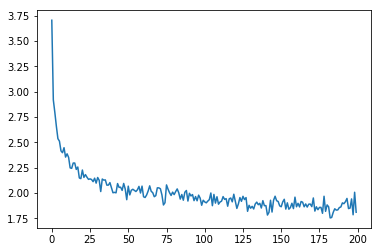

In [58]:
for i in range(10):
    print(evaluate("Happy birthday!", 100))

plt.figure()
plt.plot(all_losses)
plt.show()